In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm import tqdm

import numpy as np
import copy
import json

USE_CUDA = True

In [2]:
def readfile(data):
    with open(data, "r", encoding="utf-8") as f:
        content = f.read().splitlines()
        
    return content

def schema_load(schema_root):
    raw_dict = "".join(readfile(schema_root))
    dict2json = "".join(raw_dict.split()[2:])

    json_acceptable_string = dict2json.replace("'", "\"")
    schema = json.loads(json_acceptable_string)
    
    return schema

def define_entity(schema):
    tag_type = list(schema['tagging'])
    
    entity_tag = []
    for k in list(schema['entity'].keys()):
        entity_tag.append(schema['entity'][k]['tag'])
        
    TAG = []
    for t in tag_type:
        for e in entity_tag:
            if t!='O':
                TAG.append(t+'-'+e)  
                
    TAG = [UNKOWN_TAG, PAD_TAG] + TAG + ['O']   

    return TAG

def tag2ix(TAG):
    tag_to_ix={t:i for i,t in enumerate(TAG)}
    return tag_to_ix

def define_relation(schema):
    relation_type = list(schema['relation'])
    
    relation_tag = []
    for k in list(schema['relation'].keys()):
        relation_tag.append(schema['relation'][k]['tag'])
    
    relation_tag = [REL_PAD] + [REL_NONE] + relation_tag
        
    return relation_tag

# ==================================================

def get_word_and_label(_content, start_w, end_w):
    word_list = []
    ent_list = []
    rel_list = []
    
    for word_set in _content[start_w:end_w]:
        word_set = word_set.split()
        if len(word_set)==1:
            word_list.append(' ')
            ent_list.append('O')
            rel_list.append(REL_NONE)
        
        else:
            word_list.append(word_set[0])
            ent_list.append(word_set[1])

            try:
                testerror = word_set[2]
            except IndexError:
                rel_list.append(REL_NONE)
            else:
                rel_list.append(word_set[2:])
    
    return word_list, ent_list, rel_list

def split_to_list(content):
    init = 0
    word_list = []
    ent_list = []
    rel_list = []

    for now_token, c in enumerate(content):
        if c=='':
            words, ents, rels = get_word_and_label(content, init, now_token)
            init = now_token+1
            word_list.append(words)
            ent_list.append(ents)
            rel_list.append(rels)
            
    return word_list, ent_list, rel_list

# ==================================================

def word2index(word_list):
    word_to_ix = {"<UNKNOWN>":0, "<PAD>":1}
    for sentence in word_list:
        for word in sentence:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
                
    return word_to_ix

def dict_inverse(tag_to_ix):
    ix_to_tag = {v: k for k, v in tag_to_ix.items()}
    return ix_to_tag

def index2tag(indexs, ix_to):
    to_tags = [ix_to[i] for i in indexs.cpu().numpy()]
    return to_tags

# ==================================================

def find_max_len(word_list):
    max_len = 0
    for i in range(len(word_list)):
        if max_len<len(word_list[i]):
            max_len=len(word_list[i])
            
    return max_len

# ====== filter the length of sentence more than MAX_LEN =======

def filter_len(word_list):
    reserved_index = []
    for i in range(len(word_list)):
        if len(word_list[i])<MAX_LEN:
            reserved_index.append(i)
            
    return reserved_index


def filter_sentence(reserved_index, word_list, ent_list, rel_list):
    filter_word = list(word_list[i] for i in reserved_index)
    filter_ent = list(ent_list[i] for i in reserved_index)
    filter_rel = list(rel_list[i] for i in reserved_index)
    return filter_word, filter_ent, filter_rel

# ==================================================

def pad_seq(seq, isrel):
    if isrel:
        seq += [REL_NONE for i in range(MAX_LEN-len(seq))]
    else:
        seq += [PAD_TAG for i in range(MAX_LEN-len(seq))]
    return seq

def pad_all(filter_word, filter_ent, filter_rel):
    input_padded = [pad_seq(s, False) for s in filter_word]
    ent_padded = [pad_seq(s, False) for s in filter_ent]
    rel_padded = [pad_seq(s, True) for s in filter_rel]
    
    return input_padded, ent_padded, rel_padded

def deep_copy_lists(filter_word, filter_ent, filter_rel):
    f_w = copy.deepcopy(filter_word)
    f_e = copy.deepcopy(filter_ent)
    f_r = copy.deepcopy(filter_rel)
    
    return f_w, f_e, f_r

# ==================================================

def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix:
            idxs.append(to_ix[UNKOWN_TAG])
        else:
            idxs.append(to_ix[w])
    
#     idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def prepare_all(seqs, to_ix):
    seq_list = []
    for i in range(len(seqs)):
        seq_list.append(prepare_sequence(seqs[i], to_ix))
        
    seq_list = torch.stack(seq_list)
        
    return seq_list



def prepare_rel(rel_padded, to_ix):
    
    rel_ptr = torch.zeros(len(rel_padded), MAX_LEN, MAX_LEN, dtype=torch.long) 
    
    # 對當前的token，去比較之前所有出現過的entity，是否有關係，建成矩陣
    # [B*ML*ML]，第二維ML是當前token，第三維ML是根據當前token對之前出現過的entity紀錄關係，以index紀錄
    for i, rel_seq in enumerate(rel_padded):
        rel_dict = {}
        for j, token_seq in enumerate(rel_seq):
            rel_ptr[i][j][:j+1] = 1
            if token_seq != REL_NONE:
                for k, rel in enumerate(token_seq):

                    # if 是第一次出現，紀錄後面數字(標第幾對)和關係位置(A OR B)
                    # 假如下次出現又是同個關係位置(A)，依然紀錄
                    # 直到下次出現關係位置B，依照之前紀錄的A位置的字，然後在第三維去標關係

                    rel_token = rel.split('-')
                    if rel_token[1] not in rel_dict:
                        rel_dict[rel_token[1]] = {'rel':rel_token[0], 'loc':rel_token[2], 'idx':[j]}

                    elif rel_token[1] in rel_dict and rel_dict[rel_token[1]]['loc']==rel_token[2]:
                        rel_dict[rel_token[1]]['idx'].append(j)

                    else:
                        record_loc = rel_dict[rel_token[1]]['idx']
                        for idxx in record_loc:
                            rel_ptr[i][j][idxx] = to_ix[rel_token[0]]
                            
    return rel_ptr
                


# ==================================================

def dataload(input_var, ent_var, rel_var, raw_input):
    torch_dataset = Data.TensorDataset(input_var, ent_var, rel_var, raw_input)

    loader = Data.DataLoader(
        dataset=torch_dataset,      # torch TensorDataset format
        batch_size=BATCH_SIZE,      # mini batch size
        shuffle=True,               
        num_workers=2,       
#         drop_last=True
    )
    
    return loader

# ==================================================
def softmax_entity(entity):
    entity = entity.view(BATCH_SIZE,ent_size).argmax(1)
    return entity

In [3]:
class Attn(nn.Module):
    def __init__(self, attn_input, attn_output, rel_size):
        super(Attn, self).__init__()
        
        self.attn_input = attn_input
        self.attn_output = attn_output
        self.rel_size = rel_size
        
        self.w1 = nn.Linear(self.attn_input, self.attn_output)
        self.w2 = nn.Linear(self.attn_input, self.attn_output)
        self.tanh = nn.Tanh()
        self.v = nn.Linear(self.attn_output, self.rel_size, bias=False)
        self.softmax = nn.LogSoftmax(dim=2)
        
        
    def forward(self, encoder_outputs):
        
        decoder = encoder_outputs[:,-1,:].unsqueeze(1)                       #B*1*(ts+LE) [128,1,8]
        encoder_score = self.w1(encoder_outputs)                             #B*now len*ATTN_OUT
        decoder_score = self.w2(decoder)                                     #B*1*ATTN_OUT
        energy = self.tanh(encoder_score+decoder_score)                      #B*now len*ATTN_OUT            
        
        energy = self.v(energy)                                              #B*now len*rel_size
        
        
        # 針對每個entity做softmax，去顯示他們的關係權重
        # 主要都會是rel_none
        # 對第二維(rel)做softmax
        p = self.softmax(energy)                                         #B*now len*rel_size
        
        return p
    

In [4]:
class Entity_Typing(nn.Module):
    def __init__(self, vocab_size, ent_tag_to_ix, embedding_dim, hidden_dim1, hidden_dim2, \
                 label_embed_dim, rel_tag_to_ix):
        
        super(Entity_Typing, self).__init__()
        self.embedding_dim = embedding_dim                   #E
        self.hidden_dim1 = hidden_dim1                       #h1
        self.hidden_dim2 = hidden_dim2                       #h2
        self.label_embed_dim = label_embed_dim               #LE
        self.vocab_size = vocab_size                         #vs
        self.ent_to_ix = ent_tag_to_ix
        self.ent_size = len(ent_tag_to_ix)                   #es
        self.rel_to_ix = rel_tag_to_ix
        self.rel_size = len(rel_tag_to_ix)                   #rs           
        
        self.dropout = nn.Dropout(p=0.3)
        self.bn = nn.BatchNorm1d(DENSE_OUT, momentum=0.5, affine=False)
        
        
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        
#         self.bilstm = nn.LSTM(embedding_dim, hidden_dim1 // 2,
#                             num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)        
        self.bilstm = nn.GRU(embedding_dim, hidden_dim1 // 2,
                            num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)
        
        
        self.dense = nn.Linear(hidden_dim1, DENSE_OUT)
        self.top_hidden = nn.LSTMCell(DENSE_OUT+label_embed_dim, hidden_dim2)          
        

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim2, self.ent_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.label_embed = nn.Linear(self.ent_size, self.label_embed_dim)
        
        self.attn = Attn(ATTN_IN, ATTN_OUT, self.rel_size)
        
        
    def init_hidden1(self):       
        hidden = torch.randn(2*2, self.batch, self.hidden_dim1 // 2)    #4*B*(h1/2)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_hidden2(self):       
        hidden = torch.randn(self.batch, self.hidden_dim2)              #B*h2

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_label_embed(self):
        hidden = torch.zeros(self.batch, self.label_embed_dim)          #B*LE
        return hidden.cuda()if USE_CUDA else hidden
    
    def create_entity(self):
        output_tensor = torch.zeros(self.batch, MAX_LEN, self.ent_size)  #B*ML*es
        return output_tensor.cuda()if USE_CUDA else output_tensor
    
    def create_rel_matrix(self):
        rel_tensor = torch.zeros(self.batch, MAX_LEN, MAX_LEN, self.rel_size)  #B*ML*ML*rs
        return rel_tensor.cuda()if USE_CUDA else rel_tensor
    
    
        
    def forward(self, sentence):
        
        self.batch = sentence.size(0)
#         self.hidden1 = self.init_hidden1()                      #4*B*(h1/2)
        entity_tensor = self.create_entity()                    #B*ML*es
        rel_tensor = self.create_rel_matrix()                   #B*ML*ML*rs
        
        

        embeds = self.word_embeds(sentence)                     #B*ML*E,[128, 100, 20]
        
#         bilstm_out, self.hidden1 = self.bilstm(embeds, self.hidden1)
        bilstm_out, hidden1 = self.bilstm(embeds)
        # bilstm_out -> B*ML*h1,[128, 100, 10]
        # self.hidden1 -> ( 4*B*(h1/2), 4*B*(h1/2) )
        
        # bn
        bilstm_out = self.bn(bilstm_out)
        dense_out = self.dense(bilstm_out)                      #B*ML*DENSE_OUT,[128, 100, 100]
        
        
        encoder_sequence_l = [] 

        for length in range(MAX_LEN):
            now_token = dense_out[:,length,:]
            now_token = torch.squeeze(now_token, 1)
            if length==0:
                
#                 fake_hidden=(100)
#                 noise_x = random(100)
                self.hidden2 = self.init_hidden2()
                self.zero_label_embed = self.init_label_embed()
                combine_x = torch.cat((now_token, self.zero_label_embed),1)  #B*(DENSE_OUT+LE),[128, 103]
                
            else:
#                 fake_hidden=h
                self.hidden2 = (h_next, c_next)
                combine_x = torch.cat((now_token, label),1)

            h_next, c_next = self.top_hidden(combine_x, self.hidden2)    #B*h2,[128, 8]           
            to_tags = self.hidden2tag(h_next)                            #B*es,[128, 5]            
            ent_output = self.softmax(to_tags)                               #B*es,[128, 5]             
            label = self.label_embed(ent_output)                             #B*LE,[128, 3]
            
            s_ent_output = self.softmax_entity(ent_output)
            
            
            # Assignments to Variables are in-place operations.
            # Use that variable in lots of other contexts 
            # and some of the functions require it to not change. 
            to_tags_clone = to_tags.clone()
            label_clone = label.clone()
            
            
#             for i, tag in enumerate(s_ent_output):
#                 if tag==ent_tag_to_ix['O']:
#                     to_tags_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
#                     label_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
                    
            # relation layer
#             encoder_sequence_l.append(torch.cat((to_tags,label),1)) 
            encoder_sequence_l.append(torch.cat((h_next,label),1))  
            encoder_sequence = torch.stack(encoder_sequence_l).t()     #B*len*(es+LE), [128,1,8]          

            # Calculate attention weights 
            attn_weights = self.attn(encoder_sequence)

        
            entity_tensor[:,length,:] = ent_output
            
            # rel_tensor[:,length, 頭~當前 ,:]
            rel_tensor[:,length,:length+1,:] = attn_weights

        
        
        '''NLLLoss input: Input: (N,C) where C = number of classes'''
        return entity_tensor.view(self.batch*MAX_LEN, self.ent_size), \
               rel_tensor.view(self.batch*MAX_LEN*MAX_LEN, self.rel_size)
        
        
    def softmax_entity(self, entity):
        entity = entity.view(self.batch,ent_size).argmax(1)
        return entity

In [5]:
root = '/notebooks/sinica/dataset/'
train_data = root+'facial.train'
dev_data = root+'facial.dev'
test_data = root+'facial.test'

relation_data_old = root+'facial_r.old.train'
# relation_data = root+'facial_r.train'
relation_data = root+'facial_r2.train'
schema_root = root+'schema.txt'
dev_data = root+'facial_r2.dev'
test_data = root+'facial_r2.test'


UNKOWN_TAG = "<UNKNOWN>"
PAD_TAG = "<PAD>"
REL_NONE = 'Rel-None'
REL_PAD = 'Rel-Pad'
rule = ('FUNC', 'ApplyTo', 'STAT')

schema = schema_load(schema_root)
ENT_TAG = define_entity(schema)
REL_TAG = define_relation(schema)
ent_tag_to_ix = tag2ix(ENT_TAG)
'''{'<PAD>': 1,
 '<UNKNOWN>': 0,
 'B-FUNC': 2,
 'B-STAT': 3,
 'I-FUNC': 4,
 'I-STAT': 5,
 'O': 6}'''
rel_tag_to_ix = tag2ix(REL_TAG)
'''{'ApplyTo': 2, 'Rel-None': 1, 'Rel-Pad': 0}'''

# ========hyper-parameter-set==========

ent_size = len(ent_tag_to_ix)
rel_size = len(rel_tag_to_ix)
MAX_LEN = 100
BATCH_SIZE = 18

EMBEDDING_DIM = 20
HIDDEN_DIM1 = 10
HIDDEN_DIM2 = 8
LABEL_EMBED_DIM = ent_size
DENSE_OUT = 100

# ATTN_IN = ent_size+LABEL_EMBED_DIM
ATTN_IN = HIDDEN_DIM2+LABEL_EMBED_DIM
ATTN_OUT = 6

In [6]:
def preprocess(data):
    content = readfile(data)
    word_list, ent_list, rel_list = split_to_list(content)
    word_to_ix = word2index(word_list)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    #================================================
    vocab_size = len(word_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, vocab_size, word_to_ix, reserved_index, word_list

def dev_preprocess(dev_data):
    dev_content = readfile(dev_data)
    word_list, ent_list, rel_list = split_to_list(dev_content)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, reserved_index, word_list


In [7]:
ix_to_ent_tag = dict_inverse(ent_tag_to_ix)
ix_to_rel_tag = dict_inverse(rel_tag_to_ix)
#===============================================
input_var, ent_var, rel_var, vocab_size, word_to_ix, raw_index, raw_input = preprocess(relation_data)
loader = dataload(input_var, ent_var, rel_var, raw_index)

input_dev, ent_dev, rel_dev, raw_index_dev, raw_input_dev = dev_preprocess(dev_data)
dev_loader = dataload(input_dev, ent_dev, rel_dev, raw_index_dev)

In [8]:
model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
              LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion_tag = nn.NLLLoss()
criterion_rel = nn.NLLLoss()

In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
n_iters = 70
print_every = 12
all_ent_loss = []
all_rel_loss = []
total_loss = 0 # Reset every plot_every iters
loss = 0
ent_loss = 0

start = time.time()

for epoch in tqdm(range(n_iters)):  
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(loader):
        model.train()
        optimizer.zero_grad()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        
        batchsize = batch_x.size(0)
        
        batch_ent = batch_ent.view(batchsize*MAX_LEN)
        batch_rel = batch_rel.view(batchsize*MAX_LEN*MAX_LEN)
        
        loss_ent = criterion_tag(ent_output, batch_ent.cuda() if USE_CUDA else batch_ent)
        loss_rel = criterion_rel(rel_output, batch_rel.cuda() if USE_CUDA else batch_rel)
        loss = loss_ent+loss_rel
        
        loss.backward()
#         loss.backward(retain_graph=True)
        optimizer.step()
        
        if step % print_every == 1:
            all_ent_loss.append(loss_ent.cpu())
            all_rel_loss.append(loss_rel.cpu())
        #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))
        
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        
        batchsize = batch_x.size(0)
        
        val_loss_ent = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN)) 
        val_loss_rel = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
    
    
    print("epoch: %d | ent loss %.4f | rel loss %.4f | total loss %.4f" \
          % (epoch, loss_ent, loss_rel, loss))
    print("      %s  | val ent loss %.4f | val rel loss %.4f"
          % (" "*len(str(epoch)), val_loss_ent, val_loss_rel))


  1%|▏         | 1/70 [00:07<08:40,  7.54s/it]

epoch: 0 | ent loss 0.6564 | rel loss 0.0758 | total loss 0.7322
         | val ent loss 0.6174 | val rel loss 0.0686


  3%|▎         | 2/70 [00:15<08:41,  7.66s/it]

epoch: 1 | ent loss 0.4045 | rel loss 0.0227 | total loss 0.4273
         | val ent loss 0.3455 | val rel loss 0.0201


  4%|▍         | 3/70 [00:22<08:20,  7.47s/it]

epoch: 2 | ent loss 0.3261 | rel loss 0.0137 | total loss 0.3398
         | val ent loss 0.2872 | val rel loss 0.0118


  6%|▌         | 4/70 [00:30<08:15,  7.51s/it]

epoch: 3 | ent loss 0.3271 | rel loss 0.0108 | total loss 0.3379
         | val ent loss 0.2436 | val rel loss 0.0084


  7%|▋         | 5/70 [00:37<08:11,  7.57s/it]

epoch: 4 | ent loss 0.2861 | rel loss 0.0090 | total loss 0.2952
         | val ent loss 0.2684 | val rel loss 0.0074


  9%|▊         | 6/70 [00:44<07:56,  7.44s/it]

epoch: 5 | ent loss 0.2235 | rel loss 0.0080 | total loss 0.2315
         | val ent loss 0.2173 | val rel loss 0.0066


 10%|█         | 7/70 [00:52<07:48,  7.44s/it]

epoch: 6 | ent loss 0.1818 | rel loss 0.0067 | total loss 0.1885
         | val ent loss 0.1673 | val rel loss 0.0072


 11%|█▏        | 8/70 [00:59<07:40,  7.43s/it]

epoch: 7 | ent loss 0.1713 | rel loss 0.0077 | total loss 0.1789
         | val ent loss 0.1583 | val rel loss 0.0065


 13%|█▎        | 9/70 [01:06<07:33,  7.43s/it]

epoch: 8 | ent loss 0.1324 | rel loss 0.0053 | total loss 0.1377
         | val ent loss 0.1516 | val rel loss 0.0050


 14%|█▍        | 10/70 [01:14<07:27,  7.47s/it]

epoch: 9 | ent loss 0.1627 | rel loss 0.0052 | total loss 0.1679
         | val ent loss 0.1239 | val rel loss 0.0040


 16%|█▌        | 11/70 [01:22<07:20,  7.46s/it]

epoch: 10 | ent loss 0.1111 | rel loss 0.0039 | total loss 0.1150
          | val ent loss 0.1153 | val rel loss 0.0034


 17%|█▋        | 12/70 [01:30<07:15,  7.51s/it]

epoch: 11 | ent loss 0.1225 | rel loss 0.0042 | total loss 0.1267
          | val ent loss 0.1266 | val rel loss 0.0036


 19%|█▊        | 13/70 [01:37<07:09,  7.53s/it]

epoch: 12 | ent loss 0.1093 | rel loss 0.0036 | total loss 0.1130
          | val ent loss 0.1230 | val rel loss 0.0032


 20%|██        | 14/70 [01:44<06:59,  7.50s/it]

epoch: 13 | ent loss 0.1103 | rel loss 0.0037 | total loss 0.1140
          | val ent loss 0.1067 | val rel loss 0.0029


 21%|██▏       | 15/70 [01:52<06:51,  7.48s/it]

epoch: 14 | ent loss 0.0983 | rel loss 0.0031 | total loss 0.1014
          | val ent loss 0.0974 | val rel loss 0.0027


 23%|██▎       | 16/70 [01:59<06:44,  7.49s/it]

epoch: 15 | ent loss 0.0778 | rel loss 0.0027 | total loss 0.0805
          | val ent loss 0.1021 | val rel loss 0.0022


 24%|██▍       | 17/70 [02:07<06:38,  7.52s/it]

epoch: 16 | ent loss 0.0865 | rel loss 0.0032 | total loss 0.0897
          | val ent loss 0.0928 | val rel loss 0.0028


 26%|██▌       | 18/70 [02:15<06:30,  7.52s/it]

epoch: 17 | ent loss 0.0715 | rel loss 0.0026 | total loss 0.0741
          | val ent loss 0.0995 | val rel loss 0.0027


 27%|██▋       | 19/70 [02:23<06:25,  7.55s/it]

epoch: 18 | ent loss 0.0809 | rel loss 0.0031 | total loss 0.0840
          | val ent loss 0.0797 | val rel loss 0.0022


 29%|██▊       | 20/70 [02:30<06:16,  7.53s/it]

epoch: 19 | ent loss 0.0639 | rel loss 0.0025 | total loss 0.0664
          | val ent loss 0.0772 | val rel loss 0.0022


 30%|███       | 21/70 [02:38<06:09,  7.53s/it]

epoch: 20 | ent loss 0.0621 | rel loss 0.0028 | total loss 0.0648
          | val ent loss 0.0787 | val rel loss 0.0021


 31%|███▏      | 22/70 [02:45<06:01,  7.53s/it]

epoch: 21 | ent loss 0.0536 | rel loss 0.0024 | total loss 0.0560
          | val ent loss 0.0809 | val rel loss 0.0022


 33%|███▎      | 23/70 [02:53<05:53,  7.53s/it]

epoch: 22 | ent loss 0.0570 | rel loss 0.0024 | total loss 0.0594
          | val ent loss 0.0597 | val rel loss 0.0021


 34%|███▍      | 24/70 [03:00<05:46,  7.54s/it]

epoch: 23 | ent loss 0.0508 | rel loss 0.0023 | total loss 0.0531
          | val ent loss 0.1069 | val rel loss 0.0025


 36%|███▌      | 25/70 [03:08<05:39,  7.54s/it]

epoch: 24 | ent loss 0.0508 | rel loss 0.0027 | total loss 0.0535
          | val ent loss 0.0724 | val rel loss 0.0016


 37%|███▋      | 26/70 [03:16<05:31,  7.54s/it]

epoch: 25 | ent loss 0.0485 | rel loss 0.0028 | total loss 0.0513
          | val ent loss 0.0774 | val rel loss 0.0023


 39%|███▊      | 27/70 [03:23<05:24,  7.54s/it]

epoch: 26 | ent loss 0.0385 | rel loss 0.0021 | total loss 0.0406
          | val ent loss 0.0674 | val rel loss 0.0018


 40%|████      | 28/70 [03:31<05:17,  7.55s/it]

epoch: 27 | ent loss 0.0520 | rel loss 0.0024 | total loss 0.0544
          | val ent loss 0.0557 | val rel loss 0.0018


 41%|████▏     | 29/70 [03:39<05:09,  7.55s/it]

epoch: 28 | ent loss 0.0333 | rel loss 0.0021 | total loss 0.0355
          | val ent loss 0.0647 | val rel loss 0.0018


 43%|████▎     | 30/70 [03:47<05:03,  7.59s/it]

epoch: 29 | ent loss 0.0330 | rel loss 0.0020 | total loss 0.0350
          | val ent loss 0.0803 | val rel loss 0.0018


 44%|████▍     | 31/70 [03:56<04:57,  7.62s/it]

epoch: 30 | ent loss 0.0287 | rel loss 0.0018 | total loss 0.0305
          | val ent loss 0.0367 | val rel loss 0.0018


 46%|████▌     | 32/70 [04:03<04:49,  7.62s/it]

epoch: 31 | ent loss 0.0333 | rel loss 0.0021 | total loss 0.0355
          | val ent loss 0.0511 | val rel loss 0.0020


 47%|████▋     | 33/70 [04:11<04:41,  7.61s/it]

epoch: 32 | ent loss 0.0259 | rel loss 0.0018 | total loss 0.0277
          | val ent loss 0.0620 | val rel loss 0.0016


 49%|████▊     | 34/70 [04:19<04:34,  7.62s/it]

epoch: 33 | ent loss 0.0307 | rel loss 0.0022 | total loss 0.0329
          | val ent loss 0.0496 | val rel loss 0.0019


 50%|█████     | 35/70 [04:25<04:25,  7.59s/it]

epoch: 34 | ent loss 0.0233 | rel loss 0.0022 | total loss 0.0255
          | val ent loss 0.0409 | val rel loss 0.0018


 51%|█████▏    | 36/70 [04:32<04:17,  7.57s/it]

epoch: 35 | ent loss 0.0173 | rel loss 0.0018 | total loss 0.0191
          | val ent loss 0.0518 | val rel loss 0.0015


 53%|█████▎    | 37/70 [04:39<04:09,  7.55s/it]

epoch: 36 | ent loss 0.0224 | rel loss 0.0019 | total loss 0.0244
          | val ent loss 0.0649 | val rel loss 0.0011


 54%|█████▍    | 38/70 [04:46<04:01,  7.54s/it]

epoch: 37 | ent loss 0.0189 | rel loss 0.0016 | total loss 0.0205
          | val ent loss 0.0757 | val rel loss 0.0013


 56%|█████▌    | 39/70 [04:53<03:53,  7.54s/it]

epoch: 38 | ent loss 0.0192 | rel loss 0.0016 | total loss 0.0208
          | val ent loss 0.0299 | val rel loss 0.0013


 57%|█████▋    | 40/70 [05:00<03:45,  7.52s/it]

epoch: 39 | ent loss 0.0134 | rel loss 0.0018 | total loss 0.0152
          | val ent loss 0.0423 | val rel loss 0.0013


 59%|█████▊    | 41/70 [05:08<03:37,  7.51s/it]

epoch: 40 | ent loss 0.0165 | rel loss 0.0019 | total loss 0.0184
          | val ent loss 0.0486 | val rel loss 0.0015


 60%|██████    | 42/70 [05:15<03:30,  7.51s/it]

epoch: 41 | ent loss 0.0096 | rel loss 0.0019 | total loss 0.0116
          | val ent loss 0.0427 | val rel loss 0.0013


 61%|██████▏   | 43/70 [05:22<03:22,  7.51s/it]

epoch: 42 | ent loss 0.0101 | rel loss 0.0017 | total loss 0.0119
          | val ent loss 0.0241 | val rel loss 0.0014


 63%|██████▎   | 44/70 [05:30<03:15,  7.51s/it]

epoch: 43 | ent loss 0.0113 | rel loss 0.0013 | total loss 0.0126
          | val ent loss 0.0371 | val rel loss 0.0015


 64%|██████▍   | 45/70 [05:37<03:07,  7.50s/it]

epoch: 44 | ent loss 0.0127 | rel loss 0.0018 | total loss 0.0145
          | val ent loss 0.0736 | val rel loss 0.0015


 66%|██████▌   | 46/70 [05:44<02:59,  7.49s/it]

epoch: 45 | ent loss 0.0105 | rel loss 0.0017 | total loss 0.0122
          | val ent loss 0.0658 | val rel loss 0.0015


 67%|██████▋   | 47/70 [05:51<02:51,  7.48s/it]

epoch: 46 | ent loss 0.0193 | rel loss 0.0014 | total loss 0.0206
          | val ent loss 0.0163 | val rel loss 0.0016


 69%|██████▊   | 48/70 [05:58<02:44,  7.47s/it]

epoch: 47 | ent loss 0.0255 | rel loss 0.0018 | total loss 0.0273
          | val ent loss 0.0653 | val rel loss 0.0015


 70%|███████   | 49/70 [06:05<02:36,  7.47s/it]

epoch: 48 | ent loss 0.0161 | rel loss 0.0015 | total loss 0.0175
          | val ent loss 0.0552 | val rel loss 0.0011


 71%|███████▏  | 50/70 [06:13<02:29,  7.47s/it]

epoch: 49 | ent loss 0.0110 | rel loss 0.0015 | total loss 0.0125
          | val ent loss 0.0457 | val rel loss 0.0014


 73%|███████▎  | 51/70 [06:21<02:21,  7.47s/it]

epoch: 50 | ent loss 0.0095 | rel loss 0.0017 | total loss 0.0112
          | val ent loss 0.0680 | val rel loss 0.0012


 74%|███████▍  | 52/70 [06:28<02:14,  7.48s/it]

epoch: 51 | ent loss 0.0077 | rel loss 0.0012 | total loss 0.0090
          | val ent loss 0.0451 | val rel loss 0.0012


 76%|███████▌  | 53/70 [06:36<02:07,  7.48s/it]

epoch: 52 | ent loss 0.0077 | rel loss 0.0015 | total loss 0.0092
          | val ent loss 0.0388 | val rel loss 0.0011


 77%|███████▋  | 54/70 [06:43<01:59,  7.48s/it]

epoch: 53 | ent loss 0.0071 | rel loss 0.0013 | total loss 0.0084
          | val ent loss 0.0678 | val rel loss 0.0011


 79%|███████▊  | 55/70 [06:48<01:51,  7.43s/it]

epoch: 54 | ent loss 0.0080 | rel loss 0.0015 | total loss 0.0095
          | val ent loss 0.0714 | val rel loss 0.0011


 80%|████████  | 56/70 [06:55<01:43,  7.43s/it]

epoch: 55 | ent loss 0.0151 | rel loss 0.0015 | total loss 0.0166
          | val ent loss 0.0576 | val rel loss 0.0011


 81%|████████▏ | 57/70 [07:03<01:36,  7.44s/it]

epoch: 56 | ent loss 0.0113 | rel loss 0.0014 | total loss 0.0127
          | val ent loss 0.0449 | val rel loss 0.0010


 83%|████████▎ | 58/70 [07:11<01:29,  7.44s/it]

epoch: 57 | ent loss 0.0050 | rel loss 0.0012 | total loss 0.0062
          | val ent loss 0.0500 | val rel loss 0.0010


 84%|████████▍ | 59/70 [07:19<01:21,  7.44s/it]

epoch: 58 | ent loss 0.0060 | rel loss 0.0011 | total loss 0.0070
          | val ent loss 0.0586 | val rel loss 0.0011


 86%|████████▌ | 60/70 [07:25<01:14,  7.43s/it]

epoch: 59 | ent loss 0.0051 | rel loss 0.0014 | total loss 0.0064
          | val ent loss 0.0269 | val rel loss 0.0012


 87%|████████▋ | 61/70 [07:32<01:06,  7.42s/it]

epoch: 60 | ent loss 0.0042 | rel loss 0.0011 | total loss 0.0053
          | val ent loss 0.0620 | val rel loss 0.0010


 89%|████████▊ | 62/70 [07:40<00:59,  7.42s/it]

epoch: 61 | ent loss 0.0091 | rel loss 0.0012 | total loss 0.0104
          | val ent loss 0.0503 | val rel loss 0.0012


 90%|█████████ | 63/70 [07:47<00:51,  7.42s/it]

epoch: 62 | ent loss 0.0049 | rel loss 0.0013 | total loss 0.0063
          | val ent loss 0.0277 | val rel loss 0.0010


 91%|█████████▏| 64/70 [07:55<00:44,  7.42s/it]

epoch: 63 | ent loss 0.0127 | rel loss 0.0015 | total loss 0.0142
          | val ent loss 0.0394 | val rel loss 0.0008


 93%|█████████▎| 65/70 [08:03<00:37,  7.43s/it]

epoch: 64 | ent loss 0.0063 | rel loss 0.0012 | total loss 0.0074
          | val ent loss 0.0627 | val rel loss 0.0016


 94%|█████████▍| 66/70 [08:10<00:29,  7.43s/it]

epoch: 65 | ent loss 0.0055 | rel loss 0.0011 | total loss 0.0066
          | val ent loss 0.0707 | val rel loss 0.0012


 96%|█████████▌| 67/70 [08:17<00:22,  7.43s/it]

epoch: 66 | ent loss 0.0050 | rel loss 0.0011 | total loss 0.0060
          | val ent loss 0.0780 | val rel loss 0.0014


 97%|█████████▋| 68/70 [08:25<00:14,  7.44s/it]

epoch: 67 | ent loss 0.0063 | rel loss 0.0011 | total loss 0.0074
          | val ent loss 0.0509 | val rel loss 0.0010


 99%|█████████▊| 69/70 [08:33<00:07,  7.44s/it]

epoch: 68 | ent loss 0.0042 | rel loss 0.0012 | total loss 0.0055
          | val ent loss 0.0598 | val rel loss 0.0010


100%|██████████| 70/70 [08:40<00:00,  7.43s/it]

epoch: 69 | ent loss 0.0057 | rel loss 0.0010 | total loss 0.0067
          | val ent loss 0.0388 | val rel loss 0.0012


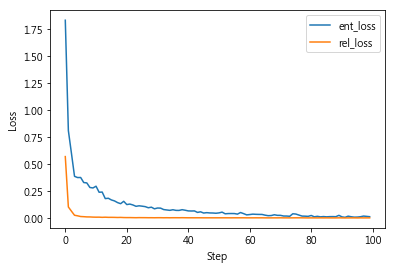

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(all_ent_loss[:100], label='ent_loss')
plt.plot(all_rel_loss[:100], label='rel_loss')
plt.xlabel("Step")
plt.ylabel("Loss") 
plt.legend()
plt.show()

In [12]:
import random
def random_choose(input_var):
    r_choose = []
    for i in range(BATCH_SIZE):
        r_choose.append(random.randint(0,len(input_var)))
    return r_choose
        
def ent_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,ent_size).argmax(2)
    return output

def rel_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,MAX_LEN,rel_size).argmax(3)
    return output

In [13]:
# Check predictions after training
with torch.no_grad():
    r_choose = random_choose(input_var)
    model.eval()
    ent_output, rel_output = model(input_var[r_choose].cuda() if USE_CUDA else input_var)
    
    batchsize = input_var[r_choose].size(0)
    
    ent_loss = criterion_tag(ent_output.cpu(), ent_var[r_choose].view(BATCH_SIZE*MAX_LEN))
    ent_output = ent_argmax(ent_output, batchsize)
    
    rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(BATCH_SIZE*MAX_LEN*MAX_LEN))
    
    
#     print('predict :', ent_output[0])
#     print('true :', ent_var[r_choose[0]])
    print()
    print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
    print('true :', index2tag(ent_var[r_choose[0]], ix_to_ent_tag))
    print()
    print('===================================================')
    print()
    print()
    print('predict :', index2tag(ent_output[1], ix_to_ent_tag))
    print('true :', index2tag(ent_var[r_choose[1]], ix_to_ent_tag))
    
    print()
    print("Entity loss : %.4f" % ent_loss)
    print("Relation loss : %.4f" % rel_loss)


predict : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
true : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O'

In [14]:
with torch.no_grad():
    r_choose = random_choose(input_dev)

    model.eval()
    ent_output, rel_output = model(input_dev[r_choose].cuda() if USE_CUDA else input_dev)
    
    batchsize = input_dev[r_choose].size(0)
    
    ent_loss = criterion_tag(ent_output.cpu(), ent_dev[r_choose].view(batchsize*MAX_LEN))
    ent_output = ent_argmax(ent_output, batchsize)
    
    rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(batchsize*MAX_LEN*MAX_LEN))
    
    print(r_choose[0])
    print()
    print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
    print()
    print('true :', index2tag(ent_dev[r_choose[0]], ix_to_ent_tag))
    print()

    print("Entity loss : %.4f" % ent_loss)
    print("Relation loss : %.4f" % rel_loss)

36

predict : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

true : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O'

In [15]:
from sklearn.metrics import precision_recall_fscore_support

# *****測多關係
# 每個epoch print recall validation 
# 處理單句
# 之後可做，自動標rel

def batch_decode(ent_output, rel_output, batch_index, word_lists, true_ent, true_rel):
    rel_lists = []
    true_rel_lists = []
    combine_outputs = []
    combine_trues = []
    
    #================
    
    
    for e,r,i,te,tr in zip(ent_output, rel_output, batch_index, true_ent, true_rel):
        
        # 單句decode關係
        true_r_list, appear_error = decode_rel(te, tr)   # true
        r_list, appear_error = decode_rel(e, r)          # predict
        
        # 出現error，跳過這句
        if appear_error:
            continue
            
        true_rel_lists.append(true_r_list)
        rel_lists.append(r_list)
        
        # 算句子長度
        len_of_list = len(word_lists[i])
        word_list = word_lists[i]
        
        true_ent = index2tag(te, ix_to_ent_tag)
        pridict_ent = index2tag(e, ix_to_ent_tag)
        
        print(word_list)
        print(true_ent[:len_of_list])
        print(true_r_list[:len_of_list])

        print()
        print('Predict output')
        print(pridict_ent[:len_of_list])
        print(r_list[:len_of_list])
        print()
        print("=====================================")
        
        # 重新組成跟input data同樣的形式
        for word in range(len_of_list):
            # ========predict======================
            add_r = ''
            if type(r_list[word]) is list: 
                for single_r in r_list[word]:
                    add_r = add_r+single_r+' '
            combine_outputs.append(word_list[word]+' '+pridict_ent[word]+' '+add_r)
            
            # ==================true===================
            add_r = ''
            if type(true_r_list[word]) is list:     
                for single_r in true_r_list[word]:
                    try :
                        add_r = add_r+single_r+' '
                    except TypeError:
                        add_r = add_r+' '
                    
            combine_trues.append(word_list[word]+' '+true_ent[word]+' '+add_r)
                  
            
        combine_outputs.append(" ")
        combine_trues.append(" ")
      
    
    # 過濾 O tag的 index
    f_ix = filter_otag(combine_trues)
    
    filter_true = list(combine_trues[i] for i in f_ix)
    filter_output = list(combine_outputs[i] for i in f_ix)

#     print(np.array(filter_output))
#     print(np.array(filter_true))
    print()
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(filter_true, filter_output, average='micro', \
                                          labels=np.unique(filter_output)))        
    
    return filter_true, filter_output
    

    
def create_rel_info(ent_output):
    r_list = []     # 存放完整關係
    r_dict = {}     # 記錄關係資訊
    appear_error = False
    pred_ent = index2tag(ent_output, ix_to_ent_tag)

    e_loc = 0       # 當前遇到的entity的位置
    for loc, e in enumerate(pred_ent):
        if e[0]=='B':
            e_loc = loc
            r_dict[loc] = {
                '_2ndtag':e[2:],
                'end':loc,
            }
            r_list.append([])
                   
        elif e[0]=='I':
            
            # 錯誤來自於，entity預測錯誤，沒有預測到B tag，直接跳到I tag
            # 所以沒有紀錄e_loc
            try: 
                r_dict[e_loc]['end'] = loc
            except KeyError:
                appear_error = True
                break
                
            r_list.append([])
            
        else:
            r_list.append("")
              
    return r_list, r_dict, appear_error



def decode_rel(ent_output, rel_output):

    r_list, r_dict, appear_error = create_rel_info(ent_output)
    
    
    IsB = False           # 是否遇到B tag的lock
    IsNext = False        # 是否為B tag後面的tag 的lock
    num_reocrd = -1       # 紀錄pair數
    now_loc = 0
    end_loc = 0
    rel_keyerror = False
    
    for now in range(len(rel_output)):
        for loc, rel in enumerate(rel_output[now][:now+1]):
            rel = rel.cpu().numpy()
            
            # 有關係存在，且為B tag 
            if rel!=rel_tag_to_ix[REL_NONE] and IsB==False and IsNext==False:

                IsB = True
                IsNext = True
                tag = ix_to_rel_tag[int(rel)]
                num_reocrd+=1
                now_loc = loc
                
                # 錯誤來自於，now_loc找不到，也就是說，rel預測出來是有關係存在
                # 但預測是'O'
                # 而在entity中卻沒有預測出來，所以r_dict中沒有紀錄
                try:
                    end_loc = r_dict[now_loc]['end']
                except KeyError:
                    rel_keyerror = True
                    break
                
                
                second_tag = r_dict[now_loc]['_2ndtag']
                # check_loc 之後有多關係出現時要更改
                preAorB = check_loc(second_tag)
                nowAorB = 'B' if preAorB=='A' else 'A'
                
                pre_complete_rel = tag+"-"+str(num_reocrd)+"-"+preAorB
                now_complete_rel = tag+"-"+str(num_reocrd)+"-"+nowAorB
                
                # 將以前的token填上關係
                for token in range(now_loc, end_loc+1):
                    
                    '''AttributeError: 'str' object has no attribute 'append'''
                    r_list[token].append(pre_complete_rel)
                
                # 當前token填上關係
                r_list[now].append(now_complete_rel)

            
            # B tag後面的tag
            elif rel!=rel_tag_to_ix[REL_NONE] and IsB:
                # 如果還在這個entity的範圍內
                if loc<=end_loc:
                    pass
                
                # 超出現在這個entity的範圍，改lock
                else:
                    IsB = False
            
            # B tag後面的tag的關係，依照前面的關係複製
            elif rel!=rel_tag_to_ix[REL_NONE] and IsNext:
                r_list[now] = r_list[now-1]
                
            else:
                IsB = False
        
        if rel_keyerror:
            rel_keyerror = False
            break
                
                
    return r_list, appear_error
                

# 是三元關係中的前者還是後者                
# 有多種關係資料後這段要改
def check_loc(second_tag):
    if second_tag in rule[0]:
        return 'A'
    elif second_tag in rule[2]:
        return 'B'
    
    
def filter_otag(combine_trues):
    ix2eval = []
    
    for i, token in enumerate(combine_trues):
        # error : string index out of range
        # 出現空白
        try :
            token[2]!='O'
        except IndexError:
            continue
        else:
            if token[2]!='O':
                ix2eval.append(i)
            
    return ix2eval

In [16]:
# This is version 2

from sklearn.metrics import precision_recall_fscore_support

# *****測多關係
# 處裡奇怪的BUG
# 每個epoch print recall validation 
# 之後可做，自動標rel

def batch_decode(ent_output, rel_output, batch_index, word_lists, true_ent, true_rel):
    rel_lists = []
    true_rel_lists = []
    combine_outputs = []
    combine_trues = []
    
    #================
    
    
    for e,r,i,te,tr in zip(ent_output, rel_output, batch_index, true_ent, true_rel):
        
        # 單句decode關係
        true_r_list, appear_error = decode_rel(te, tr)   # true
        r_list, appear_error = decode_rel(e, r)          # predict
        
        true_r_list = [list(set(i)) if type(i) is list else i for i in true_r_list]
        r_list = [list(set(i)) if type(i) is list else i for i in r_list]
        
        # 出現error，跳過這句
        if appear_error:
            continue
            
        true_rel_lists.append(true_r_list)
        rel_lists.append(r_list)
        
        # 算句子長度
        len_of_list = len(word_lists[i])
        word_list = word_lists[i]
        
        true_ent = index2tag(te, ix_to_ent_tag)
        pridict_ent = index2tag(e, ix_to_ent_tag)
        
        print(word_list)
        print(true_ent[:len_of_list])
        print(true_r_list[:len_of_list])

        print()
        print('Predict output')
        print(pridict_ent[:len_of_list])
        print(r_list[:len_of_list])
        print()
        print("=====================================")
        
        # 重新組成跟input data同樣的形式
        for word in range(len_of_list):
            # ========predict======================
            add_r = ''
            if type(r_list[word]) is list: 
                for single_r in r_list[word]:
                    add_r = add_r+single_r+' '
            combine_outputs.append(word_list[word]+' '+pridict_ent[word]+' '+add_r)
            
            # ==================true===================
            add_r = ''
            if type(true_r_list[word]) is list:     
                for single_r in true_r_list[word]:
                    try :
                        add_r = add_r+single_r+' '
                    except TypeError:
                        add_r = add_r+' '
                    
            combine_trues.append(word_list[word]+' '+true_ent[word]+' '+add_r)
                  
            
        combine_outputs.append(" ")
        combine_trues.append(" ")
      
    
    # 過濾 O tag的 index
    f_ix = filter_otag(combine_trues)
    
    filter_true = list(combine_trues[i] for i in f_ix)
    filter_output = list(combine_outputs[i] for i in f_ix)

#     print(np.array(filter_output))
#     print(np.array(filter_true))
    print()
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(filter_true, filter_output, average='micro', \
                                          labels=np.unique(filter_output)))        
    
    return filter_true, filter_output
    

    
def create_rel_info(ent_output):
    r_list = []     # 存放完整關係
    r_dict = {}     # 記錄關係資訊
    appear_error = False

    pred_ent = index2tag(ent_output, ix_to_ent_tag)
    

    e_loc = 0       # 當前遇到的entity的位置
    for loc, e in enumerate(pred_ent):
        if e[0]=='B':
            e_loc = loc
            r_dict[loc] = {
                '_2ndtag':e[2:],
                'end':loc,
            }
            r_list.append([])
                   
        elif e[0]=='I':
            # 錯誤來自於，entity預測錯誤，沒有預測到B tag，直接跳到I tag
            # 所以沒有紀錄e_loc
            try: 
                r_dict[e_loc]['end'] = loc
            except KeyError:
                appear_error = True
                break
            
            r_list.append([])
            
        else:
            r_list.append("")
              
    return r_list, r_dict, appear_error



def decode_rel(ent_output, rel_output):

    r_list, r_dict, appear_error = create_rel_info(ent_output) 
    
    '''{9: {'end': 10, '_2ndtag': 'FUNC'}, 11: {'end': 14, '_2ndtag': 'STAT'}, 20: {'end': 21, '_2ndtag': 'FUNC'}}
['', '', '', '', '', '', '', '', '', [], [], [], [], [], [], '', '', '', '', '', [], [], '', ...'''
    
    IsB = False           # 是否遇到B tag的lock
    IsNext = False        # 是否為B tag後面的tag 的lock
    num_reocrd = -1       # 紀錄pair數
    now_loc = 0
    pre_rel_end_loc = 0
    now_rel_end_loc = 0
    
    rel_keyerror = False
    
    for now in range(len(rel_output)):
        for loc, rel in enumerate(rel_output[now][:now+1]):
            rel = rel.cpu().numpy()
            
#             print(rel, IsB, IsNext)
            
            # 有關係存在，且為B tag 
            if rel!=rel_tag_to_ix[REL_NONE] and IsB==False and IsNext==False:

                IsB = True
                IsNext = True
                tag = ix_to_rel_tag[int(rel)]
                num_reocrd+=1
                now_loc = loc
                
                # 錯誤來自於，now_loc找不到，也就是說，rel預測出來是有關係存在
                # 但預測是'O'
                # 而在entity中卻沒有預測出來，所以r_dict中沒有紀錄
                try:
                    pre_rel_end_loc = r_dict[now_loc]['end']

                except KeyError:
                    rel_keyerror = True
                    break
                    
                
                try:
                    now_rel_end_loc = r_dict[now]['end']
                    
                except KeyError:
                    rel_keyerror = True
                    break
            
             
                second_tag = r_dict[now_loc]['_2ndtag']
                # check_loc 之後有多關係出現時要更改
                preAorB = check_loc(second_tag)
                nowAorB = 'B' if preAorB=='A' else 'A'
                
                pre_complete_rel = tag+"-"+str(num_reocrd)+"-"+preAorB
                now_complete_rel = tag+"-"+str(num_reocrd)+"-"+nowAorB
                
                # 將以前的token填上關係
                for token in range(now_loc, pre_rel_end_loc+1):
                    
                    '''AttributeError: 'str' object has no attribute 'append'''
                    r_list[token].append(pre_complete_rel)
                
                # 當前token填上關係
                r_list[now].append(now_complete_rel)
                

            
            # 關係前位中B tag後面的tag
            elif rel!=rel_tag_to_ix[REL_NONE] and IsB:
                # 如果還在這個entity的範圍內
                if loc<=pre_rel_end_loc:
#                     print('loc', loc)
#                     print('pre_rel_end_loc', pre_rel_end_loc)
                    pass
                
                # 超出現在這個entity的範圍，改lock
                else:
#                     print('loc', loc)
#                     print('pre_rel_end_loc', pre_rel_end_loc)
                    IsB = False

            
            # B tag後面的tag的關係，依照前面的關係複製
            elif rel!=rel_tag_to_ix[REL_NONE] and IsNext:
                r_list[now] = r_list[now-1]
                
                
            else:
                if now<=now_rel_end_loc:
                    IsB = False
                else:
                    IsB = False
                    IsNext = False

        
        if rel_keyerror:
            rel_keyerror = False
            break
                
                
    return r_list, appear_error
                

# 是三元關係中的前者還是後者                
# 有多種關係資料後這段要改
def check_loc(second_tag):
    if second_tag in rule[0]:
        return 'A'
    elif second_tag in rule[2]:
        return 'B'
    
    
def filter_otag(combine_trues):
    ix2eval = []
    
    for i, token in enumerate(combine_trues):
        # error : string index out of range
        # 出現空白
        try :
            token[2]!='O'
        except IndexError:
            continue
        else:
            if token[2]!='O':
                ix2eval.append(i)
            
    return ix2eval

In [19]:
import warnings
warnings.filterwarnings('always') 

score_predict = []
score_true = []

with torch.no_grad():
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        
        batchsize = batch_x.size(0)
        
        ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN))
        ent_output = ent_argmax(ent_output, batchsize)
        
        rel_loss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
        rel_output = rel_argmax(rel_output, batchsize)
    
        print()    
        print("Entity loss : %.4f" % ent_loss)
        print("Relation loss : %.4f" % rel_loss)
        print()
        
        filter_true, filter_output = batch_decode(ent_output, rel_output, \
                                    batch_index, raw_input_dev, batch_ent, batch_rel)
        
        # total score
        score_predict.extend(filter_output)
        score_true.extend(filter_true)
        
        
        print()
        print('==========================')
        print('==========================')
        print()
    
    print()
    print("Total score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(score_true, score_predict, average='micro', \
                                          labels=np.unique(score_predict)))   


Entity loss : 0.0451
Relation loss : 0.0012

['當', '天', '擦', '就', '馬', '上', '覺', '得', '皮', '膚', '乾', '燥', '感', '得', '到', '舒', '緩']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

['增', '加', '肌', '膚', '彈', '性', '及', '含', '水', '量', '，', '提', '高', '保', '濕', '效', '果', '，', '防', '止', '肌', '膚', '乾', '燥', '，', '去', '除', '細', '小', '皺', '紋', '，']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-ST

['極', '效', '肌', '因', '修', '護', '巨', '藻', '、', '齒', '缘', '墨', '角', '藻', '複', '合', '水', '解', '酵', '母', '提', '取', '物', '，', '浸', '透', '濕', '潤', '乾', '燥', '肌', '膚', '，', '增', '強', '防', '護', '屏', '障', '，', '協', '同', '蘆', '薈', '、', '山', '金', '車', '及', '光', '果', '甘', '草', '植', '萃', '精', '華', '，', '深', '度', '安', '撫', '同', '時', '舒', '緩', '肌', '膚', '的', '不', '適', '，', '拋', '開', '惱', '人', '的', '乾', '燥', '缺', '水', '不', '安', '讓', '肌', '膚', '穩', '定']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['S', 't', 'e', 'p', '2', '.', '強', '化', '補', '水', '-', '嫩', '白', '蠶', '絲', '面', '膜', '-', '面', '膜', '非', '常', '薄', '貼', '，', '記', '得', '要', '把', '蠶', '絲', '面', '膜', '朝', '臉', '敷', '上', '後', '再', '把', '珍', '珠', '膜', '撕', '下', '布', '料', '採', '用', '凝', '水', '蠶', '絲', '，', '清', '透', '，', '用', '天', '然', '草', '本', '植', '物', '萃', '取', '的', '精', '華', '，', '幫', '助', '保', '濕', '，', '也', '可', '以', '舒', '緩', '一', '些', '夏', '季', '保', '養', '時', '乾', '燥', '肌', '的', '狀', '況']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', '', '', '', '', ''

['以', '上', '是', '我', '不', '會', '再', '使', '用', '此', '產', '品', '，', '也', '不', '會', '推', '薦', '親', '友', '使', '用', '的', '原', '因', '，', '最', '大', '原', '因', '是', '因', '為', '；', '居', '然', '在', '使', '用', '後', '，', '肌', '膚', '反', '而', '變', '得', '乾', '到', '發', '癢', '，', '可', '見', '產', '品', '若', '無', '法', '真', '正', '提', '供', '乾', '性', '肌', '膚', '滋', '潤', '和', '保', '濕', '的', '話', '，', '添', '加', '再', '多', '吸', '引', '消', '費', '者', '的', '成', '分', '也', '不', '見', '得', '能', '得', '到', '消', '費', '者', '的', '心']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

['露', '珠', '草', '萃', '取', '液', '晶', '華', '能', '舒', '緩', '肌', '膚', '乾', '燥', '不', '適', '並', '加', '強', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], '', '', '', '', '', ['ApplyTo-1-A'], ['ApplyTo-1-A']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], '', '', '', '', '', ['ApplyTo-1-A'], ['ApplyTo-1-A']]

['很', '適', '合', '油', '性', '膚', '質', '使', '用', '，', '但', '對', '於'


Entity loss : 0.0483
Relation loss : 0.0011

['我', '覺', '得', '這', '面', '膜', '在', '這', '價', '位', '還', '可', '以', '接', '受', '，', '尤', '其', '是', '很', '會', '過', '敏', '的', '人', '來', '說', '，', '能', '使', '用', '的', '產', '品', '不', '多', '，', '保', '濕', '度', '對', '乾', '性', '肌', '的', '我', '來', '說', '也', '還', '可', '以', '，', '這', '款', '我', '覺', '得', '可', '以', '再', '回', '購']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '

AttributeError: 'str' object has no attribute 'append'

In [20]:
test_data = root+'facial_r2.test'
input_test, ent_test, rel_test, raw_index_test, raw_input_test = dev_preprocess(test_data)
test_loader = dataload(input_test, ent_test, rel_test, raw_index_test)

In [21]:
with torch.no_grad():
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(test_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        
        batchsize = batch_x.size(0)
        
        ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(BATCH_SIZE*MAX_LEN))
        ent_output = ent_argmax(ent_output, batchsize)
        
        rel_loss = criterion_rel(rel_output.cpu(), batch_rel.view(BATCH_SIZE*MAX_LEN*MAX_LEN))
        rel_output = rel_argmax(rel_output, batchsize)
    
        print()
        
        print("Entity loss : %.4f" % ent_loss)
        print("Relation loss : %.4f" % rel_loss)
        print()
        
        batch_decode(ent_output, rel_output, batch_index, raw_input_test, \
                     batch_ent, batch_rel)
        print()
        print('==========================')
        print()


Entity loss : 0.0527
Relation loss : 0.0012

['優', '點', '：', '很', '好', '推', '，', '延', '展', '性', '也', '很', '好', '，', '也', '不', '黏', '膩', '，', '吸', '收', '程', '度', '很', '好', '，', '很', '快', '就', '推', '進', '去', '的', '感', '覺', '，', '擦', '完', '後', '，', '摸', '起', '來', '很', '好', '摸', '，', '很', '柔', '嫩', '，', '很', '平', '滑', '，', '沒', '有', '剌', '激', '感', '，', '即', '使', '是', '敏', '感', '肌', '也', '可', '以', '使', '用', '喔']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['Ap

['真', '心', '覺', '得', '這', '是', '一', '罐', '適', '合', '像', '我', '這', '樣', '敏', '感', '肌', '的', '水', '水', '使', '用', '的', '產', '品', '~', '質', '地', '溫', '和', '而', '且', '保', '濕', '度', '優', '到', '爆', '炸']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-

['看', '來', '「', 'P', 'U', 'R', 'U', 'N', 'N', 'U', 'R', 'I', '韓', '方', '去', '角', '質', '手', '工', '皂', '﹙', '艾', '草', '﹚', '」', '果', '真', '很', '適', '合', '舒', '緩', '乾', '癢', '肌', '膚', '啊']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'],

['珞', '瑜', '認', '為', '「', 'X', 'a', 'n', 't', 'i', 'a', '桑', '緹', '亞', '微', '導', '修', '護', '新', '生', '精', '華', '液', '」', '可', '讓', '肌', '膚', '保', '濕', '、', '舒', '緩', '肌', '膚', '乾', '燥', '、', '補', '充', '及', '鎖', '住', '水', '分', '、', '滋', '潤', '臉', '上', '的', '肌', '膚', '，', '使', '「', '顏', '肌', '」', '（', '指', '臉', '上', '肌', '膚', '）', '呈', '現', '透', '亮', '光', '澤']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', [], [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['質', '地', '偏', '乳', '狀', '~', '~', '很', '保', '濕', '~', '~', '我', '覺', '得', '很', '適', '合', '待', '在', '冷', '氣', '房', '和', '偏', '乾', '性', '肌', '的', '水', '水', '使', '用', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '']



AttributeError: 'str' object has no attribute 'append'

In [22]:
dev_content = readfile(dev_data)
word_list, ent_list, rel_list = split_to_list(dev_content)
reserved_index = filter_len(word_list)

In [23]:
word_list[-15]

['露',
 '珠',
 '草',
 '萃',
 '取',
 '液',
 '晶',
 '華',
 '能',
 '舒',
 '緩',
 '肌',
 '膚',
 '乾',
 '燥',
 '不',
 '適',
 '並',
 '加',
 '強',
 '保',
 '濕']

In [24]:
#### 
with torch.no_grad():
#     r_choose = random_choose(input_dev)
    input_dev, ent_dev, rel_dev, raw_index_dev, raw_input_dev = dev_preprocess(dev_data)
    
    print(input_dev[-12])
    model.eval()
    ii = torch.unsqueeze(input_dev[-12],0)
    ent_output, rel_output = model(ii.cuda() if USE_CUDA else input_dev)
    
    batchsize = ii.size(0)
    
    ent_loss = criterion_tag(ent_output.cpu(), ent_dev[-12].view(batchsize*MAX_LEN))
    ent_output = ent_argmax(ent_output, batchsize)
    
    rel_loss = criterion_rel(rel_output.cpu(), rel_var[-12].view(batchsize*MAX_LEN*MAX_LEN))
    rel_output = rel_argmax(rel_output, batchsize)
    
    print(ent_output)
    print(rel_output[0, 21])
    print(rel_output[0, 11])
    rrr = torch.unsqueeze(rel_dev[-12], 0)
    
    lll = []
    lll.append(raw_input_dev[-15])

    
    filter_true, filter_output = batch_decode(ent_output, rel_output, \
                            raw_index_dev, lll, ent_dev[-12].view(1, -1), rrr)
    

tensor([ 802,  745,  610,  598,  259,  294,  113,  293,  127,  245,
         246,   52,   70,  137,  138,   37,  281,  385,  150,   96,
          23,   24,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1])
tensor([[ 6,  6,  6,  6,  6,  6,  6,  6,  6,  3,  5,  2,  4,  4,
          4,  6,  6,  6,  6,  6,  3,  5,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1